In [45]:
from google.colab import drive
drive.mount('/content/drive')




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from matplotlib import pyplot as plt

import copy

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


In [47]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False)


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

foreground_classes = {'horse','ship', 'truck'}

background_classes = {'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog'}

# print(type(foreground_classes))

In [0]:
dataiter = iter(trainloader)
background_data=[]
background_label=[]
foreground_data=[]
foreground_label=[]
batch_size=10

for i in range(5000):
  images, labels = dataiter.next()
  for j in range(batch_size):
    if(classes[labels[j]] in background_classes):
      img = images[j].tolist()
      background_data.append(img)
      background_label.append(labels[j])
    else:
      img = images[j].tolist()
      foreground_data.append(img)
      foreground_label.append(labels[j])
            
foreground_data = torch.tensor(foreground_data)
foreground_label = torch.tensor(foreground_label)
background_data = torch.tensor(background_data)
background_label = torch.tensor(background_label)
    

In [0]:
def imshow(img):
  img = img / 2 + 0.5     # unnormalize
  npimg = img#.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

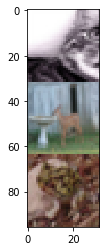

torch.Size([3, 96, 32])


In [51]:
img1 = torch.cat((background_data[0],background_data[1],background_data[2]),1)
imshow(img1)
img2 = torch.cat((background_data[27],background_data[3],background_data[43]),1)
imshow(img2)
img3 = torch.cat((img1,img2),2)
imshow(img3)
print(img2.size())


In [0]:
def create_mosaic_img(bg_idx,fg_idx,fg): 
  """
  bg_idx : list of indexes of background_data[] to be used as background images in mosaic
  fg_idx : index of image to be used as foreground image from foreground data
  fg : at what position/index foreground image has to be stored out of 0-8
  """
  image_list=[]
  j=0
  for i in range(9):
    if i != fg:
      image_list.append(background_data[bg_idx[j]].type("torch.DoubleTensor"))
      j+=1
    else: 
      image_list.append(foreground_data[fg_idx].type("torch.DoubleTensor"))
      label = foreground_label[fg_idx]-7  # minus 7 because our fore ground classes are 7,8,9 but we have to store it as 0,1,2
  #image_list = np.concatenate(image_list ,axis=0)
  image_list = torch.stack(image_list) 
  return image_list,label

In [0]:
desired_num = 30000
mosaic_list_of_images =[]      # list of mosaic images, each mosaic image is saved as list of 9 images
fore_idx =[]                   # list of indexes at which foreground image is present in a mosaic image i.e from 0 to 9               
mosaic_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(desired_num):
  bg_idx = np.random.randint(0,35000,8)
  fg_idx = np.random.randint(0,15000)
  fg = np.random.randint(0,9)
  fore_idx.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  mosaic_list_of_images.append(image_list)
  mosaic_label.append(label)



1


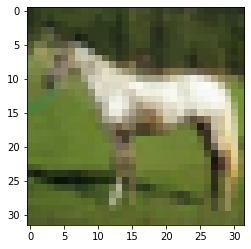

horse


In [54]:
qw=45

print(fore_idx[qw])
imshow(mosaic_list_of_images[qw][fore_idx[qw]])
# print(mosaic_list_of_images[0])
print(classes[mosaic_label[qw]+7]) # add 7 as we had subtracted 7 while saving

# imshow(mosaic_list_of_images[13][2])
# print(type(mosaic_list_of_images[1][0]))
# print(mosaic_label)

In [0]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]

batch = 250
msd = MosaicDataset(mosaic_list_of_images, mosaic_label , fore_idx)
train_loader = DataLoader( msd,batch_size= batch ,shuffle=True)

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Module1(nn.Module):
  def __init__(self):
    super(Module1, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    self.fc4 = nn.Linear(10,1)

  def forward(self, z):
    x = torch.zeros([batch,9],dtype=torch.float64)
    y = torch.zeros([batch,3, 32,32], dtype=torch.float64)
    x,y = x.to("cuda"),y.to("cuda")
    for i in range(9):
      x[:,i] = self.helper(z[:,i])[:,0]
    x = F.softmax(x,dim=1)   # alphas
    
    x1 = x[:,0]
    torch.mul(x1[:,None,None,None],z[:,0])

    for i in range(9):            
      x1 = x[:,i]          
      y = y + torch.mul(x1[:,None,None,None],z[:,i])
    return y , x 
  
  def helper(self,x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x
      


In [0]:
 class Module2(nn.Module):
  def __init__(self):
    super(Module2, self).__init__()
    
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    self.fc4 = nn.Linear(10,3)

  def forward(self,y):  #z batch of list of 9 images
    y1 = self.pool(F.relu(self.conv1(y)))
    y1 = self.pool(F.relu(self.conv2(y1)))
    y1 = y1.view(-1, 16 * 5 * 5)

    y1 = F.relu(self.fc1(y1))
    y1 = F.relu(self.fc2(y1))
    y1 = F.relu(self.fc3(y1))
    y1 = self.fc4(y1)
    return y1 


In [0]:
where_net = Module1().double()
where_net = where_net.to("cuda")
# print(net.parameters)

In [0]:
# idx = np.random.randint(0,250,10)
# train_iter = iter(train_loader)
# images,labels,_=train_iter.next()

# for i in idx:
#   imshow(where_net1(images)[i].detach().numpy())

In [0]:
what_net = Module2().double()
what_net = what_net.to("cuda")

In [0]:
# where_net.load_state_dict(torch.load("model_epoch90.pt"))
# what_net.load_state_dict(torch.load("model_epoch90.pt"))
# print(fore_net.parameters)

In [0]:
test_images =[]        #list of mosaic images, each mosaic image is saved as laist of 9 images
fore_idx_test =[]                   #list of indexes at which foreground image is present in a mosaic image                
test_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(10000):
  bg_idx = np.random.randint(0,35000,8)
  fg_idx = np.random.randint(0,15000)
  fg = np.random.randint(0,9)
  fore_idx_test.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  test_images.append(image_list)
  test_label.append(label)

In [0]:
test_data = MosaicDataset(test_images,test_label,fore_idx_test)
test_loader = DataLoader( test_data,batch_size= batch ,shuffle=False)

In [64]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer_where = optim.SGD(where_net.parameters(), lr=0.01, momentum=0.9)
optimizer_what = optim.SGD(what_net.parameters(), lr=0.01, momentum=0.9)

nos_epochs = 280
every_what_epoch = 20
path = "/content/drive/My Drive/Research/stage_wise_training/where_what/alternate_training_280_every20epochs_lr_01_focus_vs_pred"
#---------------------------------------------
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0
argmax_more_than_half = 0
argmax_less_than_half =0
col1=[]
col2=[]
col3=[]
col4=[]
col5=[]
col6=[]
col7=[]
col8=[]
col9=[]
col10=[]
col11=[]
col12=[]
col13=[]
#-----------------------------------------------
train_loss=[]
test_loss =[]
train_acc = []
test_acc = []
for epoch in range(nos_epochs):  # loop over the dataset multiple times
    
  focus_true_pred_true =0
  focus_false_pred_true =0
  focus_true_pred_false =0
  focus_false_pred_false =0
  argmax_more_than_half = 0
  argmax_less_than_half =0
  
  running_loss = 0.0
  batch_correct = 0.0
  cnt=0
  total=0
  iteration = desired_num // batch



  #training data set

  if (epoch % (every_what_epoch*2) ) < every_what_epoch :
    print(epoch,"updating where_net, what_net is freezed") 
  elif (epoch % (every_what_epoch*2)) > every_what_epoch :
    print(epoch,"updating what_net, where_net is freezed")
      
    
  for i, data in  enumerate(train_loader):
      inputs , labels , fore_idx = data
      inputs,labels = inputs.to("cuda"),labels.to("cuda") 
      # zero the parameter gradients
      
      optimizer_what.zero_grad()
      optimizer_where.zero_grad()
      
      avg_images , alphas = where_net(inputs)
      outputs = what_net(avg_images)
      
      _, predicted = torch.max(outputs.data, 1)
      

      loss = criterion(outputs, labels) 
      loss.backward() 
  
      if (epoch % (every_what_epoch*2) ) < every_what_epoch :
        optimizer_where.step()
          
      elif (epoch % (every_what_epoch*2)) > every_what_epoch :
        optimizer_what.step()
          
      batch_correct += sum(predicted == labels)
      total += len(predicted)
      running_loss += loss.item()
      if cnt % 120 == 119:    # print every 40 mini-batches
          print("--"*40)
          print("Epoch: ",epoch)
#             print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, running_loss / 120))
          train_loss.append(running_loss/120)
          train_acc.append(batch_correct.item()/desired_num)
          print("total_Correct:",batch_correct.item(),"Total:",total,"train_loss",running_loss/120,"train_acc: ", batch_correct.item()/total)
          #running_loss = 0.0
      cnt=cnt+1

      if epoch % 5 == 0:
        for j in range (batch):
          focus = torch.argmax(alphas[j])

          if(alphas[j][focus] >= 0.5):
            argmax_more_than_half +=1
          else:
            argmax_less_than_half +=1

          if(focus == fore_idx[j] and predicted[j] == labels[j]):
            focus_true_pred_true += 1

          elif(focus != fore_idx[j] and predicted[j] == labels[j]):
            focus_false_pred_true +=1

          elif(focus == fore_idx[j] and predicted[j] != labels[j]):
            focus_true_pred_false +=1

          elif(focus != fore_idx[j] and predicted[j] != labels[j]):
            focus_false_pred_false +=1

  if epoch % 5 == 0:
    col1.append(epoch)
    col2.append(argmax_more_than_half)
    col3.append(argmax_less_than_half)
    col4.append(focus_true_pred_true)
    col5.append(focus_false_pred_true)
    col6.append(focus_true_pred_false)
    col7.append(focus_false_pred_false)
  
    with torch.no_grad():
      loss = 0.0
      correct = 0.0
      tot =0
      focus_true_pred_true =0
      focus_false_pred_true =0
      focus_true_pred_false =0
      focus_false_pred_false =0
      argmax_more_than_half = 0
      argmax_less_than_half =0

      for data in test_loader:
        inputs, labels , fore_idx = data
        inputs,labels = inputs.to("cuda"),labels.to("cuda") 
        avg_images , alphas = where_net(inputs)
        outputs = what_net(avg_images)
        _, predicted = torch.max(outputs.data, 1)
        loss += criterion(outputs, labels).item() 
        correct += sum(predicted == labels)
        tot += len(predicted)

        for j in range (batch):
          focus = torch.argmax(alphas[j])

          if(alphas[j][focus] >= 0.5):
            argmax_more_than_half +=1
          else:
            argmax_less_than_half +=1

          if(focus == fore_idx[j] and predicted[j] == labels[j]):
            focus_true_pred_true += 1

          elif(focus != fore_idx[j] and predicted[j] == labels[j]):
            focus_false_pred_true +=1

          elif(focus == fore_idx[j] and predicted[j] != labels[j]):
            focus_true_pred_false +=1

          elif(focus != fore_idx[j] and predicted[j] != labels[j]):
            focus_false_pred_false +=1
          
      test_loss.append(loss/40) # 10000/250 = 40
      test_acc.append(correct.item()/tot)
      print("total_Correct:",correct.item(),"Total:",tot,"test loss: ", loss/40, "test accuracy", correct.item()/tot)

    col8.append(argmax_more_than_half)
    col9.append(argmax_less_than_half)
    col10.append(focus_true_pred_true)
    col11.append(focus_false_pred_true)
    col12.append(focus_true_pred_false)
    col13.append(focus_false_pred_false)

  elif epoch % 5 != 0  :
    with torch.no_grad():
      loss = 0.0
      correct = 0.0
      tot =0
      for data in test_loader:
        inputs, labels , fore_idx = data
        inputs,labels = inputs.to("cuda"),labels.to("cuda") 
        avg_images , alphas = where_net(inputs)
        outputs = what_net(avg_images)
        _, predicted = torch.max(outputs.data, 1)
        loss += criterion(outputs, labels).item() 
        correct += sum(predicted == labels)
        tot += len(predicted)

      test_loss.append(loss/40) # 10000/250 = 40
      test_acc.append(correct.item()/tot)
      print("total_Correct:",correct.item(),"Total:",tot,"test loss: ", loss/40, "test accuracy", correct.item()/tot)
 
    
  if (epoch % (every_what_epoch*2) == every_what_epoch*2 - 1):
      torch.save(where_net.state_dict(),path + "/where_model_at_epoch"+str(epoch)+".pt")
      torch.save(what_net.state_dict(),path + "/what_model_at_epoch"+str(epoch)+".pt")
    
print('Finished Training')

torch.save(where_net.state_dict(),path + "/full_where_model_epoch"+str(nos_epochs)+".pt")
torch.save(what_net.state_dict(),path + "/full_what_model_epoch"+str(nos_epochs)+".pt")

0 updating where_net, what_net is freezed
--------------------------------------------------------------------------------
Epoch:  0
total_Correct: 9926.0 Total: 30000 train_loss 1.120392694597066 train_acc:  0.33086666666666664
total_Correct: 3316.0 Total: 10000 test loss:  1.119867915399375 test accuracy 0.3316
1 updating where_net, what_net is freezed
--------------------------------------------------------------------------------
Epoch:  1
total_Correct: 9926.0 Total: 30000 train_loss 1.1203926944588187 train_acc:  0.33086666666666664
total_Correct: 3316.0 Total: 10000 test loss:  1.1198679152736524 test accuracy 0.3316
2 updating where_net, what_net is freezed
--------------------------------------------------------------------------------
Epoch:  2
total_Correct: 9926.0 Total: 30000 train_loss 1.120392694320434 train_acc:  0.33086666666666664
total_Correct: 3316.0 Total: 10000 test loss:  1.1198679151458937 test accuracy 0.3316
3 updating where_net, what_net is freezed
----------

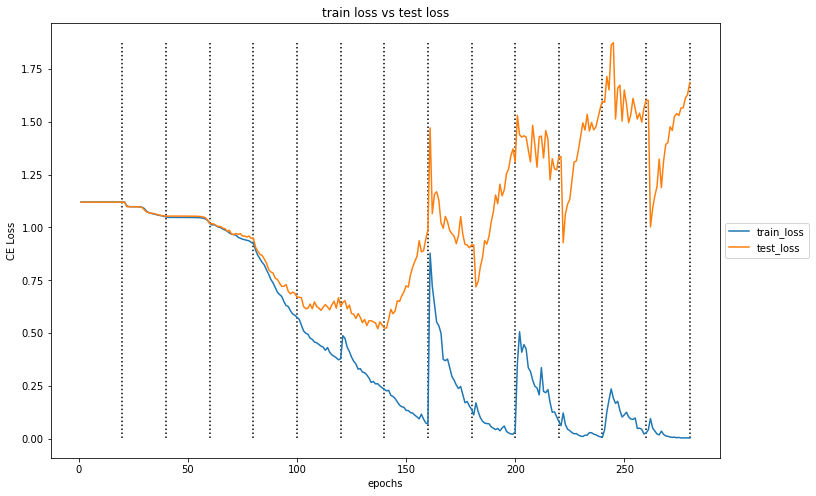

In [65]:
fig = plt.figure(figsize = (12,8) )
vline_list = np.arange(every_what_epoch, nos_epochs + every_what_epoch, every_what_epoch )
# train_loss = np.random.randn(340)
# test_loss = np.random.randn(340)
epoch_list = np.arange(1, nos_epochs+1)
plt.plot(epoch_list,train_loss, label='train_loss')
plt.plot(epoch_list,test_loss, label='test_loss')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("CE Loss")
plt.vlines(vline_list,min(min(train_loss),min(test_loss)), max(max(test_loss),max(train_loss)),linestyles='dotted')
plt.title("train loss vs test loss")
plt.show()
fig.savefig("train_test_loss_plot.pdf")


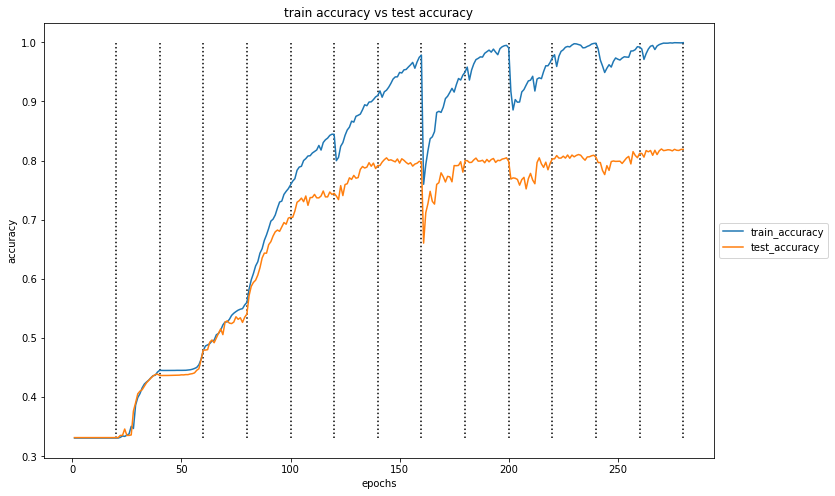

In [66]:
fig = plt.figure(figsize = (12,8) )
vline_list = np.arange(every_what_epoch, nos_epochs + every_what_epoch, every_what_epoch )
# train_acc = np.random.randn(340)
# test_acc = np.random.randn(340)
epoch_list = np.arange(1, nos_epochs+1)
plt.plot(epoch_list,train_acc, label='train_accuracy')
plt.plot(epoch_list,test_acc, label='test_accuracy')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.vlines(vline_list,min(min(train_acc),min(test_acc)), max(max(test_acc),max(train_acc)),linestyles='dotted')
plt.title("train accuracy vs test accuracy")
plt.show()
fig.savefig("train_test_acc_plot.pdf")

In [0]:
columns = ["epochs", "argmax > 0.5" ,"argmax < 0.5", "focus_true_pred_true", "focus_false_pred_true", "focus_true_pred_false", "focus_false_pred_false" ]
df_train = pd.DataFrame()
df_test = pd.DataFrame()
df_train[columns[0]] = col1
df_train[columns[1]] = col2
df_train[columns[2]] = col3
df_train[columns[3]] = col4
df_train[columns[4]] = col5
df_train[columns[5]] = col6
df_train[columns[6]] = col7

df_test[columns[0]] = col1
df_test[columns[1]] = col8
df_test[columns[2]] = col9
df_test[columns[3]] = col10
df_test[columns[4]] = col11
df_test[columns[5]] = col12
df_test[columns[6]] = col13

In [68]:
df_train

epochs  argmax > 0.5  ...  focus_true_pred_false  focus_false_pred_false
0        0             0  ...                   2043                   18031
1        5             0  ...                   2045                   18029
2       10             0  ...                   2050                   18024
3       15             0  ...                   2053                   18021
4       20             0  ...                   2047                   18027
5       25             0  ...                   1605                   18261
6       30             0  ...                   1518                   16305
7       35             0  ...                   1486                   15531
8       40             0  ...                   1506                   15141
9       45             0  ...                   2420                   14228
10      50             0  ...                   3453                   13187
11      55             0  ...                   3926                   12620
12      60           666  ...                   3419                   11986
13      65           666  ...                   3073                   11764
14      70           666  ...                   2700                   11484
15      75           666  ...                   2456                   11131
16      80          1125  ...                   2412                   10116
17      85          6886  ...                   2774                    7925
18      90         13955  ...                   2823                    6249
19      95         17427  ...                   2761                    5295
20     100         17488  ...                   2569                    4475
21     105         17488  ...                   1713                    4286
22     110         17488  ...                   1401                    4143
23     115         17488  ...                   1120                    3826
24     120         14506  ...                   1440                    4566
25     125         18153  ...                   1118                    3332
26     130         20214  ...                    980                    2724
27     135         21800  ...                    805                    2226
28     140         21692  ...                    672                    1796
29     145         21692  ...                    439                    1649
30     150         21692  ...                    357                    1200
31     155         21692  ...                    216                     804
32     160         10828  ...                   2099                    5104
33     165         15320  ...                   1369                    3161
34     170         18429  ...                    784                    2074
35     175         19563  ...                    588                    1565
36     180         20808  ...                    314                     945
37     185         20808  ...                    192                     626
38     190         20808  ...                    107                     290
39     195         20808  ...                     90                     235
40     200         18839  ...                    740                    1751
41     205         18512  ...                    730                    1790
42     210         19895  ...                    507                    1218
43     215         20049  ...                    442                    1044
44     220         22520  ...                    123                     510
45     225         22520  ...                     37                     217
46     230         22520  ...                      6                      76
47     235         22520  ...                     62                     149
48     240         21851  ...                     70                     272
49     245         20490  ...                    315                     824
50     250         20943  ...                    277                     624


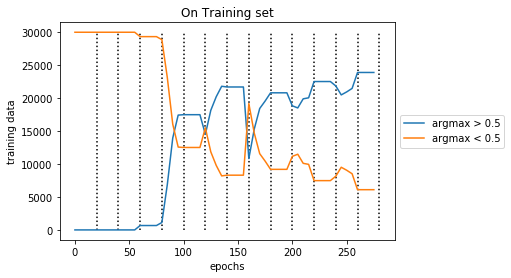

In [69]:
# plt.figure(12,12)
plt.plot(col1,col2, label='argmax > 0.5')
plt.plot(col1,col3, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.title("On Training set")
plt.vlines(vline_list,min(min(col2),min(col3)), max(max(col2),max(col3)),linestyles='dotted')
plt.show()

plt.plot(col1,col4, label ="focus_true_pred_true ")
plt.plot(col1,col5, label ="focus_false_pred_true ")
plt.plot(col1,col6, label ="focus_true_pred_false ")
plt.plot(col1,col7, label ="focus_false_pred_false ")
plt.title("On Training set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.vlines(vline_list,min(min(col4),min(col5),min(col6),min(col7)), max(max(col4),max(col5),max(col6),max(col7)),linestyles='dotted')
plt.show()

In [70]:
df_test

epochs  argmax > 0.5  ...  focus_true_pred_false  focus_false_pred_false
0        0             0  ...                    693                    5991
1        5             0  ...                    695                    5989
2       10             0  ...                    693                    5991
3       15             0  ...                    691                    5993
4       20             0  ...                    699                    5985
5       25             0  ...                    529                    6118
6       30             0  ...                    488                    5411
7       35             0  ...                    473                    5205
8       40             0  ...                    499                    5135
9       45             0  ...                    788                    4844
10      50             0  ...                   1164                    4460
11      55             0  ...                   1286                    4304
12      60           237  ...                   1210                    3994
13      65           237  ...                   1080                    3920
14      70           237  ...                    930                    3780
15      75           237  ...                    861                    3823
16      80           819  ...                    863                    3422
17      85          2235  ...                   1064                    2748
18      90          4958  ...                   1088                    2283
19      95          5840  ...                   1025                    2095
20     100          5645  ...                    996                    1964
21     105          5645  ...                    732                    1963
22     110          5645  ...                    628                    1944
23     115          5645  ...                    637                    1977
24     120          4955  ...                    727                    1872
25     125          6159  ...                    661                    1731
26     130          6072  ...                    659                    1629
27     135          7118  ...                    578                    1458
28     140          6701  ...                    574                    1510
29     145          6701  ...                    519                    1468
30     150          6701  ...                    471                    1499
31     155          6701  ...                    535                    1559
32     160          3777  ...                    802                    2594
33     165          3800  ...                    898                    1838
34     170          5126  ...                    713                    1649
35     175          6139  ...                    596                    1491
36     180          6384  ...                    503                    1498
37     185          6384  ...                    503                    1507
38     190          6384  ...                    515                    1506
39     195          6384  ...                    484                    1517
40     200          5863  ...                    648                    1665
41     205          5277  ...                    724                    1598
42     210          5361  ...                    698                    1632
43     215          5679  ...                    686                    1429
44     220          6917  ...                    494                    1477
45     225          6917  ...                    486                    1472
46     230          6917  ...                    473                    1440
47     235          6917  ...                    474                    1465
48     240          6410  ...                    523                    1511
49     245          5297  ...                    696                    1470
50     250          6602  ...                    483                    1528


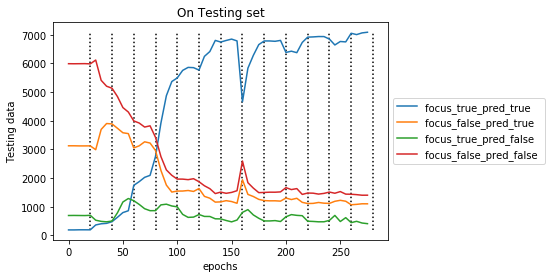

In [71]:
# plt.figure(12,12)
plt.plot(col1,col8, label='argmax > 0.5')
plt.plot(col1,col9, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("Testing data")
plt.title("On Testing set")
plt.vlines(vline_list,min(min(col8),min(col9)), max(max(col8),max(col9)),linestyles='dotted')
plt.show()

plt.plot(col1,col10, label ="focus_true_pred_true ")
plt.plot(col1,col11, label ="focus_false_pred_true ")
plt.plot(col1,col12, label ="focus_true_pred_false ")
plt.plot(col1,col13, label ="focus_false_pred_false ")
plt.title("On Testing set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("Testing data")
plt.vlines(vline_list,min(min(col10),min(col11),min(col12),min(col13)), max(max(col10),max(col11),max(col12),max(col13)),linestyles='dotted')
plt.show()

In [72]:
print("-"*20,"Training Dataset","-"*20)
print("epochs", col1) 
print("argmax > 0.5 ", col2) 
print("argmax < 0.5 ", col3) 
print("focus_true_pred_true", col4) 
print("focus_false_pred_true", col5)
print("focus_true_pred_false", col6) 
print("focus_false_pred_false", col7) 
print("-"*20,"Testing Dataset","-"*20)
print("argmax > 0.5 ", col8)
print("argmax < 0.5", col9) 
print("focus_true_pred_true", col10) 
print("focus_false_pred_true", col11)
print("focus_true_pred_false", col12) 
print("focus_false_pred_false", col13) 

-------------------- Training Dataset --------------------
epochs [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275]
argmax > 0.5  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 666, 666, 666, 666, 1125, 6886, 13955, 17427, 17488, 17488, 17488, 17488, 14506, 18153, 20214, 21800, 21692, 21692, 21692, 21692, 10828, 15320, 18429, 19563, 20808, 20808, 20808, 20808, 18839, 18512, 19895, 20049, 22520, 22520, 22520, 22520, 21851, 20490, 20943, 21477, 23895, 23895, 23895, 23895]
argmax < 0.5  [30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 29334, 29334, 29334, 29334, 28875, 23114, 16045, 12573, 12512, 12512, 12512, 12512, 15494, 11847, 9786, 8200, 8308, 8308, 8308, 8308, 19172, 14680, 11571, 10437, 9192, 9192, 9192, 9192, 11161, 11488, 10105, 9951, 7480, 7480, 74

In [0]:
df_train.to_csv(path + "/focus_vs_predicted_train.csv")
df_test.to_csv(path + "/focus_vs_predicted_test.csv")

In [0]:
def display(img):
  img = img / 2 + 0.5     # unnormalize
  npimg = img
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

****************************************************************************************************


tensor([3.2217e-01, 3.3630e-04, 2.3711e-01, 3.5237e-01, 2.2391e-02, 1.6349e-02,
        4.2875e-02, 6.2377e-03, 1.4949e-04], device='cuda:0',
       dtype=torch.float64)


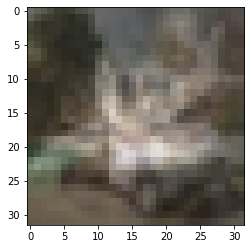

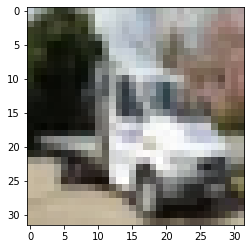

predicted truck
true truck
****************************************************************************************************


tensor([0.0245, 0.2674, 0.0194, 0.0346, 0.1156, 0.1031, 0.0093, 0.0014, 0.4246],
       device='cuda:0', dtype=torch.float64)


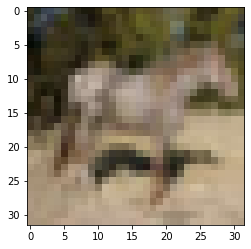

predicted horse
true horse
****************************************************************************************************


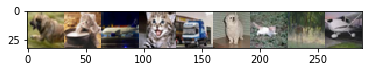

tensor([0.0387, 0.0332, 0.0259, 0.0033, 0.7509, 0.0306, 0.0746, 0.0386, 0.0042],
       device='cuda:0', dtype=torch.float64)


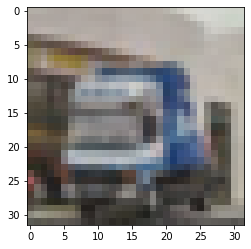

predicted truck
true truck
****************************************************************************************************


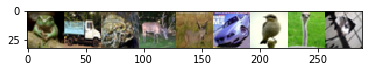

tensor([1.6732e-04, 9.9217e-01, 2.7615e-03, 2.4246e-03, 9.5289e-04, 7.8989e-04,
        9.9165e-05, 4.3928e-05, 5.9374e-04], device='cuda:0',
       dtype=torch.float64)


predicted truck
true truck
****************************************************************************************************


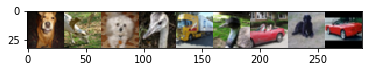

tensor([0.0124, 0.0055, 0.0030, 0.0062, 0.9583, 0.0019, 0.0050, 0.0061, 0.0016],
       device='cuda:0', dtype=torch.float64)


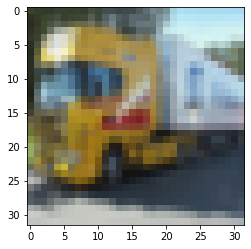

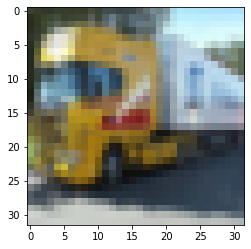

predicted truck
true truck
****************************************************************************************************


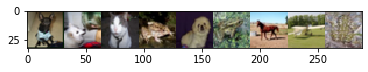

tensor([0.0022, 0.0513, 0.0505, 0.0868, 0.0154, 0.1471, 0.4444, 0.0038, 0.1985],
       device='cuda:0', dtype=torch.float64)


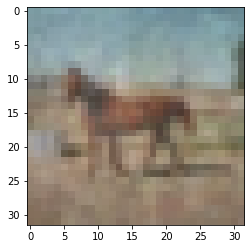

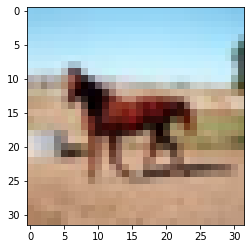

predicted horse
true horse
****************************************************************************************************


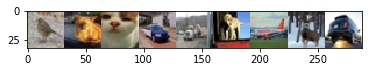

tensor([1.0615e-03, 9.4296e-04, 1.3674e-03, 5.0677e-03, 7.3027e-01, 1.7571e-02,
        2.4066e-01, 2.7921e-03, 2.6970e-04], device='cuda:0',
       dtype=torch.float64)


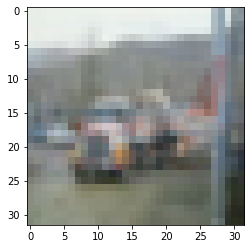

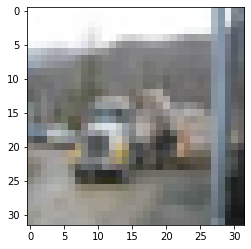

predicted truck
true truck
****************************************************************************************************


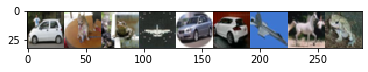

tensor([0.0355, 0.0360, 0.0033, 0.0156, 0.0267, 0.0039, 0.0056, 0.8720, 0.0014],
       device='cuda:0', dtype=torch.float64)


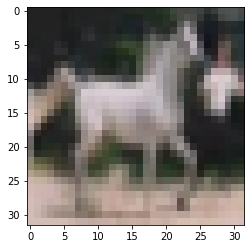

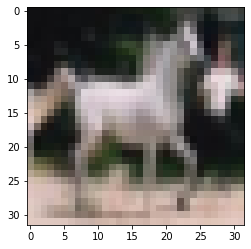

predicted horse
true horse
****************************************************************************************************


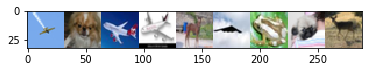

tensor([2.5383e-04, 3.5087e-02, 3.8821e-03, 1.9942e-02, 9.1197e-01, 6.8663e-06,
        5.1708e-03, 3.3345e-04, 2.3357e-02], device='cuda:0',
       dtype=torch.float64)


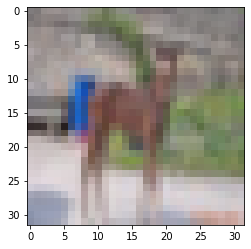

predicted horse
true horse
****************************************************************************************************


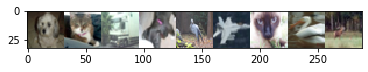

tensor([3.7337e-03, 1.9622e-02, 9.2511e-01, 5.0528e-04, 2.0087e-02, 7.2270e-03,
        3.0197e-04, 1.3258e-02, 1.0159e-02], device='cuda:0',
       dtype=torch.float64)


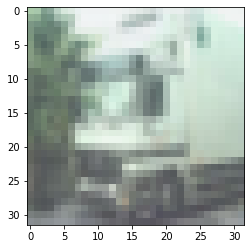

predicted truck
true truck
****************************************************************************************************


tensor([8.3871e-02, 1.1854e-03, 9.6123e-03, 8.8926e-01, 1.4566e-03, 1.0311e-02,
        6.7703e-04, 3.4724e-03, 1.5686e-04], device='cuda:0',
       dtype=torch.float64)


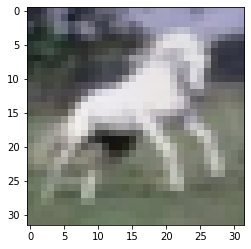

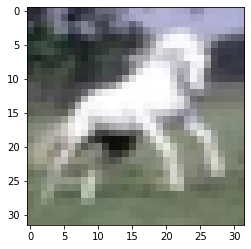

predicted horse
true horse
****************************************************************************************************


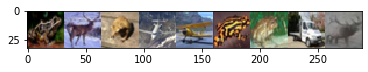

tensor([0.0715, 0.0449, 0.0175, 0.0503, 0.3354, 0.0304, 0.0353, 0.3723, 0.0424],
       device='cuda:0', dtype=torch.float64)


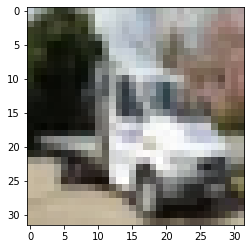

predicted truck
true truck
****************************************************************************************************


tensor([3.4155e-05, 4.5080e-05, 2.7264e-03, 1.7302e-04, 7.5254e-04, 1.0184e-03,
        9.9459e-01, 6.2446e-04, 3.4677e-05], device='cuda:0',
       dtype=torch.float64)


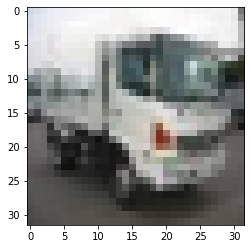

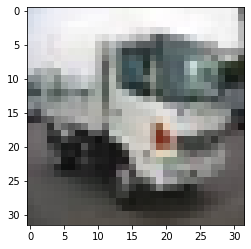

predicted truck
true truck
****************************************************************************************************


tensor([0.0338, 0.1471, 0.0608, 0.1474, 0.0203, 0.3248, 0.0164, 0.0716, 0.1778],
       device='cuda:0', dtype=torch.float64)


predicted truck
true truck
****************************************************************************************************


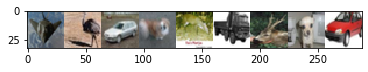

tensor([1.6421e-03, 3.6428e-02, 8.4292e-03, 2.1724e-01, 1.3852e-04, 7.2169e-01,
        4.9773e-04, 1.3242e-02, 6.8895e-04], device='cuda:0',
       dtype=torch.float64)


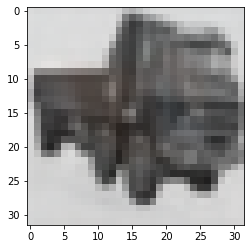

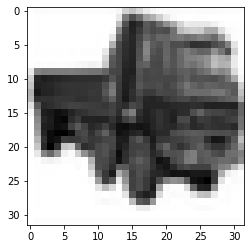

predicted truck
true truck
****************************************************************************************************


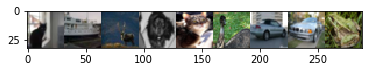

tensor([9.7805e-04, 9.3458e-01, 2.3541e-02, 1.2720e-02, 7.2757e-05, 1.1248e-02,
        1.4665e-02, 1.9927e-03, 1.9745e-04], device='cuda:0',
       dtype=torch.float64)


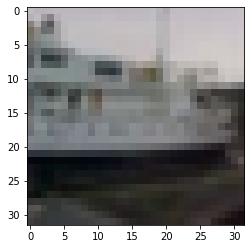

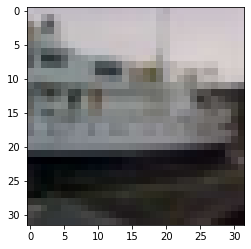

predicted ship
true ship
****************************************************************************************************


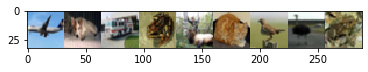

tensor([5.8610e-06, 7.0597e-03, 5.0200e-01, 2.6635e-03, 3.2713e-03, 1.9815e-02,
        3.6936e-02, 4.2252e-01, 5.7333e-03], device='cuda:0',
       dtype=torch.float64)


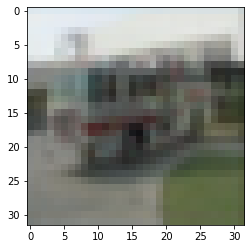

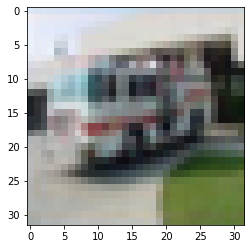

predicted truck
true truck
****************************************************************************************************


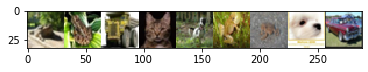

tensor([3.5350e-02, 8.6979e-03, 7.3777e-01, 2.9215e-02, 2.1561e-03, 7.1498e-04,
        1.0188e-01, 7.4664e-02, 9.5591e-03], device='cuda:0',
       dtype=torch.float64)


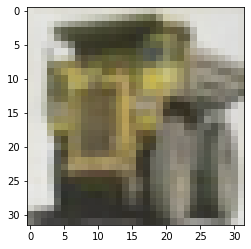

predicted truck
true truck
****************************************************************************************************


tensor([0.1004, 0.0541, 0.1391, 0.2317, 0.0136, 0.0062, 0.3293, 0.0143, 0.1112],
       device='cuda:0', dtype=torch.float64)


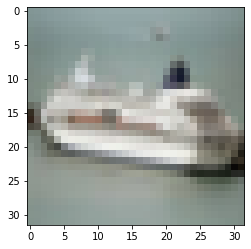

predicted ship
true ship
****************************************************************************************************


tensor([0.7205, 0.0324, 0.0163, 0.1606, 0.0097, 0.0025, 0.0197, 0.0056, 0.0327],
       device='cuda:0', dtype=torch.float64)


predicted horse
true horse
****************************************************************************************************


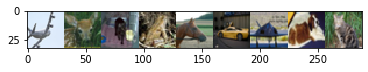

tensor([0.0100, 0.0329, 0.0683, 0.0033, 0.6642, 0.0783, 0.0063, 0.0176, 0.1192],
       device='cuda:0', dtype=torch.float64)


predicted horse
true horse
****************************************************************************************************


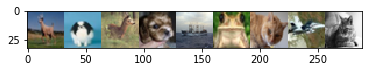

tensor([6.4444e-03, 2.6368e-03, 3.5612e-03, 1.7016e-03, 9.7413e-01, 8.1156e-04,
        1.7108e-03, 2.4311e-03, 6.5691e-03], device='cuda:0',
       dtype=torch.float64)


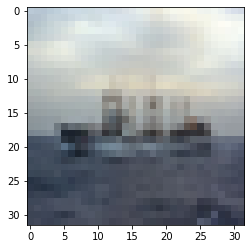

predicted ship
true ship
****************************************************************************************************


tensor([0.0553, 0.1010, 0.0163, 0.0164, 0.6439, 0.0294, 0.0209, 0.0480, 0.0687],
       device='cuda:0', dtype=torch.float64)


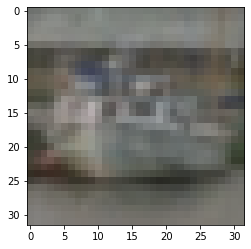

predicted ship
true ship
****************************************************************************************************


tensor([0.0467, 0.0084, 0.0101, 0.0028, 0.0451, 0.0495, 0.0019, 0.0096, 0.8261],
       device='cuda:0', dtype=torch.float64)


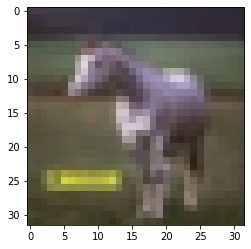

predicted horse
true horse
****************************************************************************************************


tensor([0.0532, 0.0114, 0.0190, 0.0016, 0.8012, 0.0040, 0.0925, 0.0055, 0.0116],
       device='cuda:0', dtype=torch.float64)


predicted truck
true truck
****************************************************************************************************


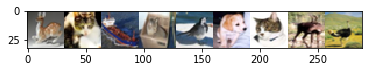

tensor([4.2897e-02, 1.4729e-04, 5.8483e-01, 1.4066e-01, 2.2419e-01, 6.4185e-04,
        6.0656e-03, 5.4849e-05, 5.0842e-04], device='cuda:0',
       dtype=torch.float64)


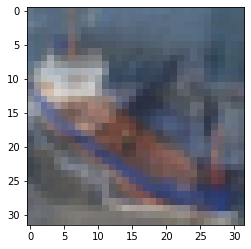

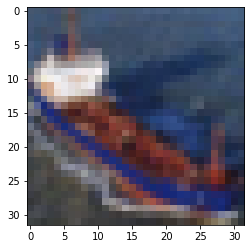

predicted ship
true ship
****************************************************************************************************


tensor([0.0045, 0.0053, 0.9233, 0.0057, 0.0031, 0.0018, 0.0221, 0.0225, 0.0116],
       device='cuda:0', dtype=torch.float64)


predicted truck
true truck
****************************************************************************************************


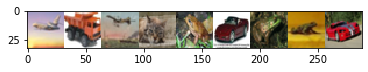

tensor([0.0266, 0.8862, 0.0209, 0.0270, 0.0135, 0.0114, 0.0009, 0.0010, 0.0126],
       device='cuda:0', dtype=torch.float64)


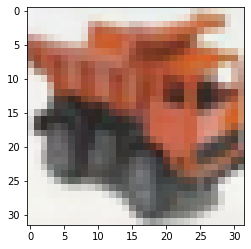

predicted truck
true truck
****************************************************************************************************


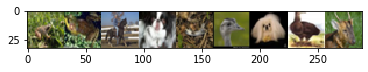

tensor([8.0211e-04, 2.5087e-04, 9.9586e-01, 4.2008e-05, 2.0522e-03, 2.3135e-04,
        4.4215e-04, 8.7067e-05, 2.2933e-04], device='cuda:0',
       dtype=torch.float64)


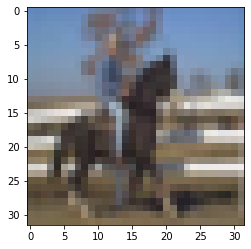

predicted horse
true horse
****************************************************************************************************


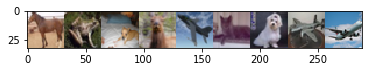

tensor([9.6349e-01, 1.1738e-04, 1.9096e-04, 1.3710e-03, 2.2015e-03, 2.9253e-02,
        1.8737e-03, 1.3013e-03, 1.9645e-04], device='cuda:0',
       dtype=torch.float64)


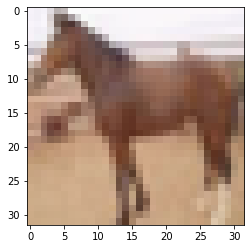

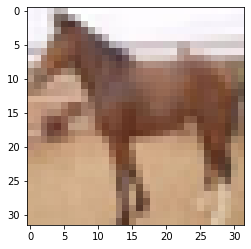

predicted horse
true horse
****************************************************************************************************


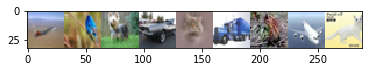

tensor([1.7904e-03, 3.0019e-05, 1.9097e-03, 7.8403e-03, 2.6209e-03, 9.7853e-01,
        1.9285e-03, 3.2398e-03, 2.1063e-03], device='cuda:0',
       dtype=torch.float64)


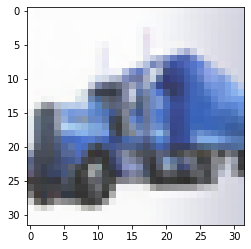

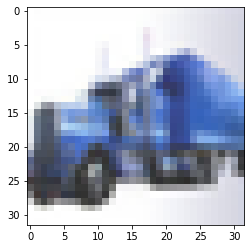

predicted truck
true truck
****************************************************************************************************


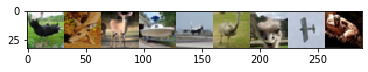

tensor([0.0700, 0.0129, 0.0620, 0.1443, 0.4080, 0.0053, 0.1848, 0.0147, 0.0980],
       device='cuda:0', dtype=torch.float64)


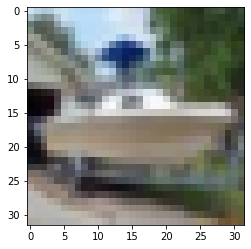

predicted ship
true ship
****************************************************************************************************


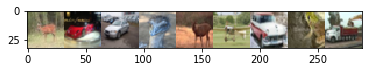

tensor([0.1596, 0.0785, 0.0243, 0.1752, 0.0720, 0.1984, 0.0176, 0.0487, 0.2256],
       device='cuda:0', dtype=torch.float64)


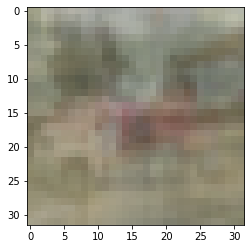

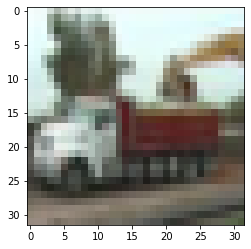

predicted truck
true truck
****************************************************************************************************


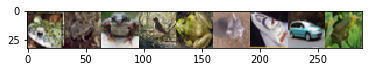

tensor([0.0354, 0.0729, 0.0920, 0.4544, 0.0238, 0.1914, 0.1001, 0.0274, 0.0026],
       device='cuda:0', dtype=torch.float64)


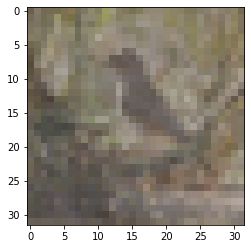

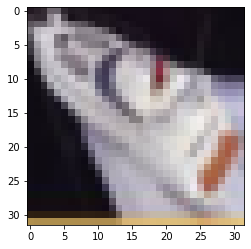

predicted ship
true ship
****************************************************************************************************


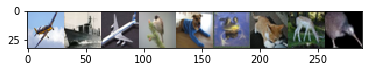

tensor([4.3056e-04, 1.6025e-01, 7.6373e-03, 3.8766e-02, 6.3935e-02, 3.9194e-02,
        4.7101e-03, 2.1912e-01, 4.6595e-01], device='cuda:0',
       dtype=torch.float64)


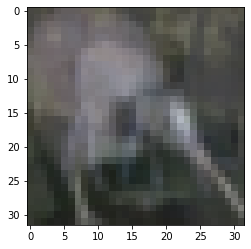

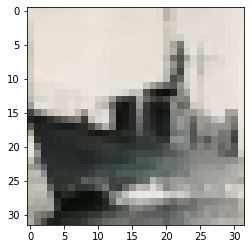

predicted ship
true ship
****************************************************************************************************


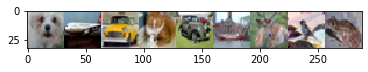

tensor([0.0051, 0.1869, 0.0009, 0.0017, 0.0054, 0.7659, 0.0161, 0.0115, 0.0066],
       device='cuda:0', dtype=torch.float64)


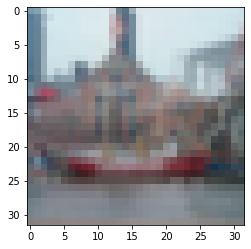

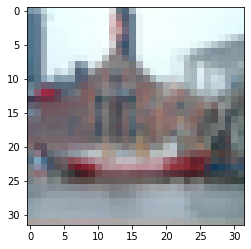

predicted ship
true ship
****************************************************************************************************


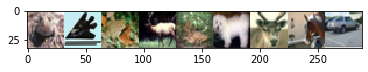

tensor([0.2377, 0.0017, 0.0601, 0.0198, 0.0168, 0.0106, 0.0189, 0.1507, 0.4836],
       device='cuda:0', dtype=torch.float64)


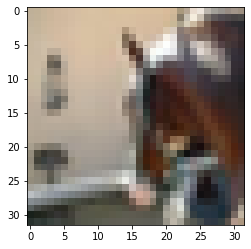

predicted horse
true horse
****************************************************************************************************


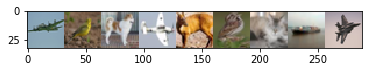

tensor([0.0100, 0.0062, 0.0022, 0.0048, 0.0096, 0.0014, 0.0255, 0.9378, 0.0025],
       device='cuda:0', dtype=torch.float64)


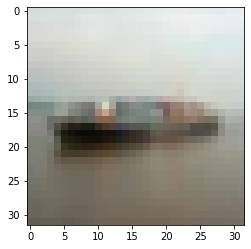

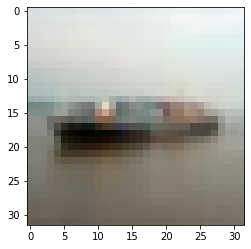

predicted ship
true ship
****************************************************************************************************


tensor([6.6967e-05, 3.6858e-03, 2.2422e-04, 1.5882e-03, 3.0356e-03, 9.7450e-01,
        8.1630e-04, 5.6850e-05, 1.6022e-02], device='cuda:0',
       dtype=torch.float64)


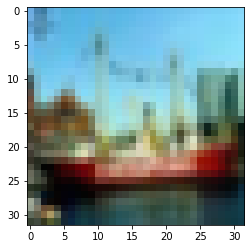

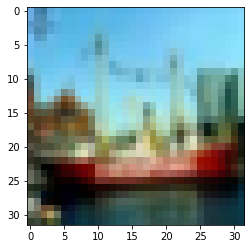

predicted ship
true ship
****************************************************************************************************


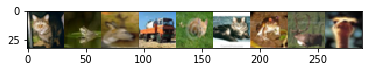

tensor([1.8912e-07, 8.8842e-07, 5.3893e-07, 9.9999e-01, 1.4831e-07, 1.3738e-06,
        1.2636e-06, 9.7580e-07, 3.7712e-07], device='cuda:0',
       dtype=torch.float64)


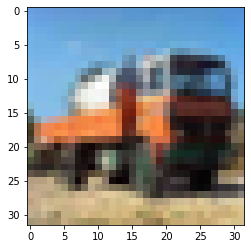

predicted truck
true truck
****************************************************************************************************


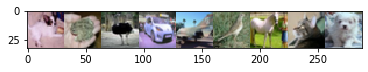

tensor([1.6582e-02, 6.2033e-03, 1.8667e-02, 8.8678e-02, 2.4939e-02, 8.7374e-03,
        8.2524e-01, 1.0398e-02, 5.5922e-04], device='cuda:0',
       dtype=torch.float64)


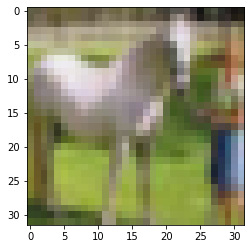

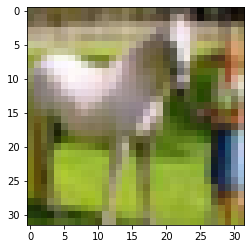

predicted horse
true horse
****************************************************************************************************


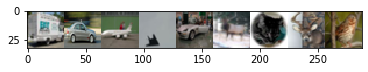

tensor([9.5048e-01, 3.0832e-03, 3.0417e-03, 9.3701e-03, 1.6520e-03, 2.3306e-02,
        4.5132e-03, 4.3171e-03, 2.3581e-04], device='cuda:0',
       dtype=torch.float64)


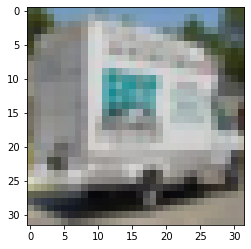

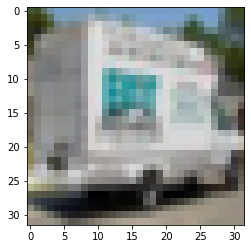

predicted truck
true truck
****************************************************************************************************


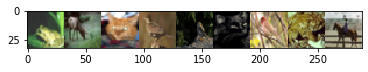

tensor([8.1966e-04, 3.4120e-04, 2.2081e-03, 1.6814e-03, 9.4957e-04, 3.2760e-03,
        4.2841e-03, 1.4636e-04, 9.8629e-01], device='cuda:0',
       dtype=torch.float64)


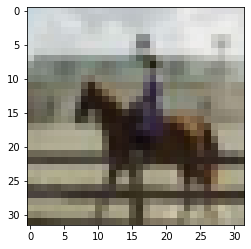

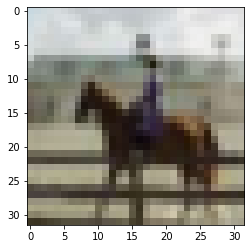

predicted horse
true horse
****************************************************************************************************


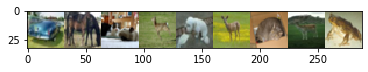

tensor([3.7631e-03, 9.9194e-01, 6.0167e-04, 2.2972e-04, 2.5012e-04, 2.2944e-04,
        8.4780e-04, 2.1117e-03, 2.7669e-05], device='cuda:0',
       dtype=torch.float64)


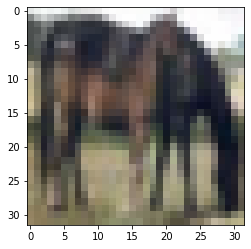

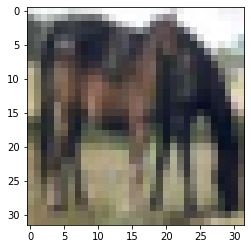

predicted horse
true horse
****************************************************************************************************


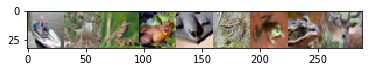

tensor([0.1534, 0.1534, 0.1447, 0.0808, 0.0267, 0.2223, 0.0441, 0.0432, 0.1313],
       device='cuda:0', dtype=torch.float64)


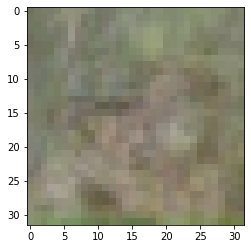

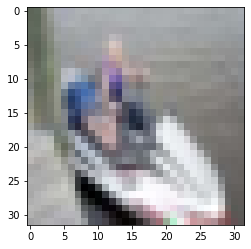

predicted ship
true ship
****************************************************************************************************


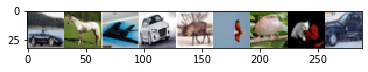

tensor([9.5798e-03, 9.8104e-01, 3.2312e-04, 1.9809e-04, 2.3971e-03, 3.1037e-05,
        6.8742e-04, 2.2888e-03, 3.4561e-03], device='cuda:0',
       dtype=torch.float64)


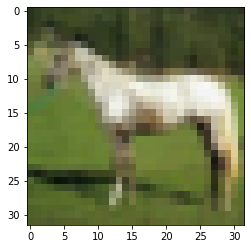

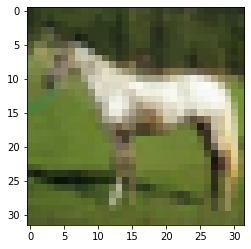

predicted horse
true horse
****************************************************************************************************


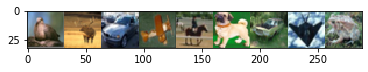

tensor([8.8339e-03, 4.7619e-04, 1.7067e-02, 6.4681e-03, 9.4902e-01, 6.5431e-04,
        1.4715e-02, 1.8133e-05, 2.7471e-03], device='cuda:0',
       dtype=torch.float64)


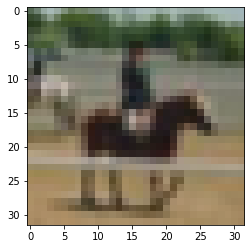

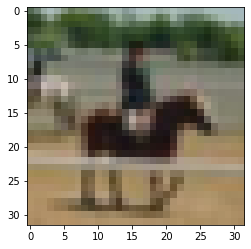

predicted horse
true horse
****************************************************************************************************


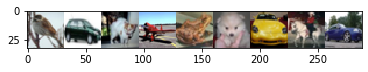

tensor([0.0011, 0.0516, 0.0088, 0.0510, 0.0292, 0.1040, 0.0115, 0.7391, 0.0036],
       device='cuda:0', dtype=torch.float64)


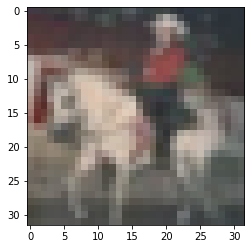

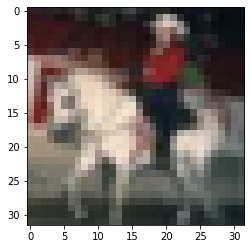

predicted horse
true horse
****************************************************************************************************


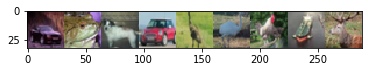

tensor([1.0657e-02, 7.4275e-03, 2.9501e-02, 6.4493e-02, 3.0848e-04, 2.5421e-02,
        6.7141e-03, 8.2747e-01, 2.8006e-02], device='cuda:0',
       dtype=torch.float64)


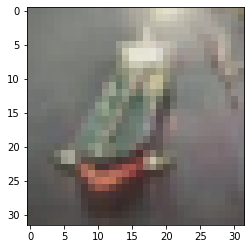

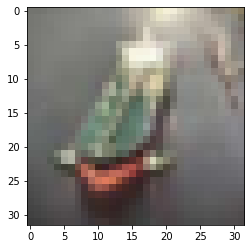

predicted ship
true ship
****************************************************************************************************


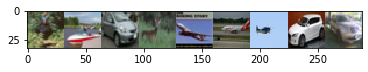

tensor([7.4216e-02, 7.4009e-01, 1.6656e-02, 7.3936e-02, 1.4011e-02, 2.6837e-02,
        4.5185e-04, 1.7444e-03, 5.2058e-02], device='cuda:0',
       dtype=torch.float64)


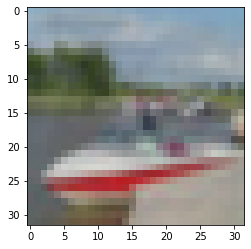

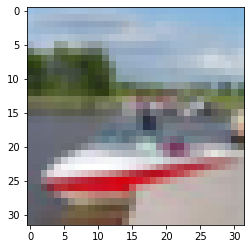

predicted ship
true ship
Accuracy of the network on the 30000 train images: 99 %
total correct 29983
total train set images 30000
focus_true_pred_true 41
focus_false_pred_true 9
focus_true_pred_false 0
focus_false_pred_false 0
argmax_more_than_half 38
argmax_less_than_half 12


In [75]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

train_loader1 = DataLoader( msd,batch_size= batch ,shuffle=False)
with torch.no_grad():
  for data in train_loader1:
    inputs, labels , fore_idx = data
    inputs,labels = inputs.to("cuda"),labels.to("cuda") 
    avg_images , alphas = where_net(inputs)
    outputs = what_net(avg_images)

    _, predicted = torch.max(outputs.data, 1)

    if flag==1 :
      for j in range (50):
        print("*"*100)
        img1 = torch.cat((inputs[j][0], inputs[j][1], inputs[j][2], inputs[j][3], inputs[j][4], inputs[j][5], inputs[j][6], inputs[j][7], inputs[j][8]) , 2)
        display(img1.cpu())

        print(alphas[j])

        img2 = avg_images[j]
        display(img2.cpu())

        img3 = inputs[j][fore_idx[j]]
        display(img3.cpu())

        print("predicted", classes[predicted[j]+7])
        print("true", classes[labels[j]+7])
        
        focus = torch.argmax(alphas[j])
      
        if(alphas[j][focus] >= 0.5):
          argmax_more_than_half +=1
        else:
          argmax_less_than_half +=1

        if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1

        elif(focus != fore_idx[j] and predicted[j] == labels[j]):
          focus_false_pred_true +=1

        elif(focus == fore_idx[j] and predicted[j] != labels[j]):
          focus_true_pred_false +=1

        elif(focus != fore_idx[j] and predicted[j] != labels[j]):
          focus_false_pred_false +=1

      flag =0

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true",focus_true_pred_true)
print("focus_false_pred_true",focus_false_pred_true )
print("focus_true_pred_false",focus_true_pred_false )
print("focus_false_pred_false",focus_false_pred_false)

print("argmax_more_than_half",argmax_more_than_half)
print("argmax_less_than_half",argmax_less_than_half)

In [0]:
test_images =[]        #list of mosaic images, each mosaic image is saved as laist of 9 images
fore_idx_test =[]                   #list of indexes at which foreground image is present in a mosaic image                
test_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(10000):
    bg_idx = np.random.randint(0,35000,8)
    fg_idx = np.random.randint(0,15000)
    fg = np.random.randint(0,9)
    fore_idx_test.append(fg)
    image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
    test_images.append(image_list)
    test_label.append(label)

In [0]:
# test_data = MosaicDataset(test_images,test_label,)
# test_loader = DataLoader( test_data,batch_size= batch ,shuffle=False)

0


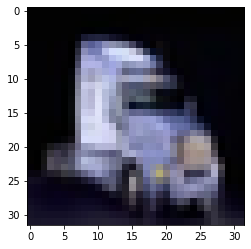

truck


In [78]:
print(fore_idx_test[0])
imshow(test_images[0][fore_idx_test[0]])
print(classes[test_label[0]+7])

****************************************************************************************************


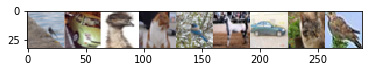

tensor([0.0069, 0.0054, 0.0015, 0.0079, 0.0425, 0.8789, 0.0075, 0.0485, 0.0010],
       device='cuda:0', dtype=torch.float64)


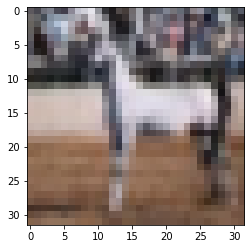

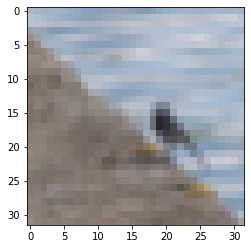

predicted horse
true horse
****************************************************************************************************


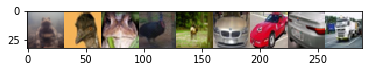

tensor([1.5150e-02, 2.0605e-04, 1.0705e-03, 4.5251e-03, 2.9589e-03, 1.4776e-03,
        1.5009e-02, 8.9525e-03, 9.5065e-01], device='cuda:0',
       dtype=torch.float64)


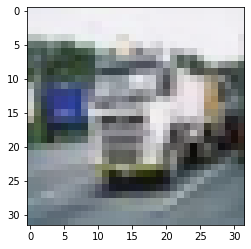

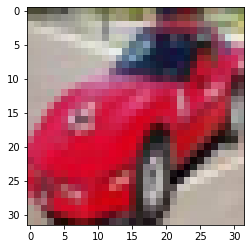

predicted truck
true truck
****************************************************************************************************


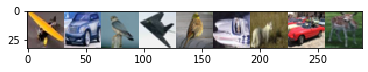

tensor([2.0055e-04, 2.6067e-03, 1.4042e-03, 1.1266e-06, 3.2796e-03, 9.8585e-01,
        6.6454e-04, 5.1271e-04, 5.4852e-03], device='cuda:0',
       dtype=torch.float64)


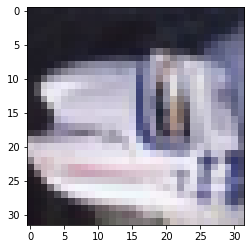

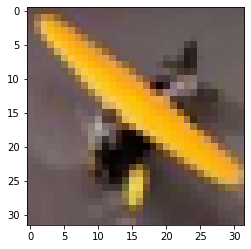

predicted ship
true ship
****************************************************************************************************


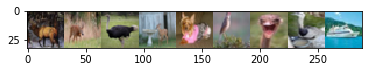

tensor([0.0456, 0.0351, 0.0136, 0.5759, 0.0289, 0.0512, 0.0908, 0.0922, 0.0667],
       device='cuda:0', dtype=torch.float64)


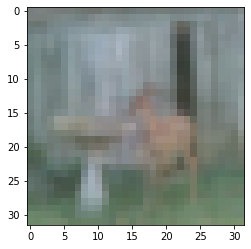

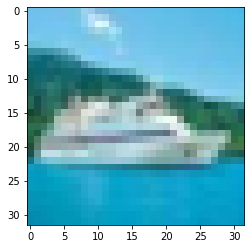

predicted ship
true ship
****************************************************************************************************


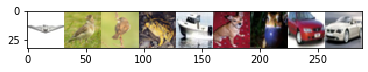

tensor([0.0347, 0.0052, 0.0370, 0.0105, 0.1769, 0.2872, 0.2928, 0.1159, 0.0399],
       device='cuda:0', dtype=torch.float64)


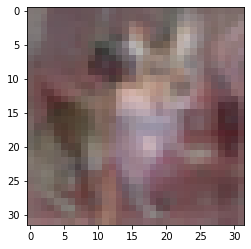

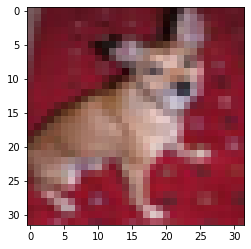

predicted horse
true ship
****************************************************************************************************


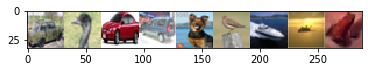

tensor([0.1084, 0.0088, 0.1435, 0.0710, 0.0105, 0.0439, 0.4610, 0.0006, 0.1524],
       device='cuda:0', dtype=torch.float64)


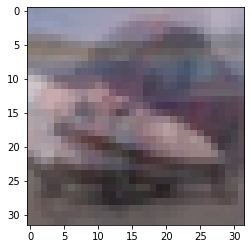

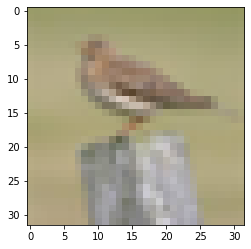

predicted horse
true ship
****************************************************************************************************


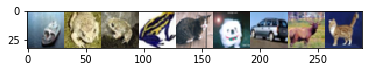

tensor([7.9251e-01, 2.6191e-02, 6.2774e-03, 3.5129e-04, 3.9347e-02, 9.5845e-03,
        5.0600e-02, 7.3925e-03, 6.7742e-02], device='cuda:0',
       dtype=torch.float64)


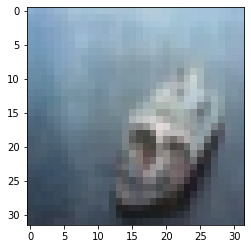

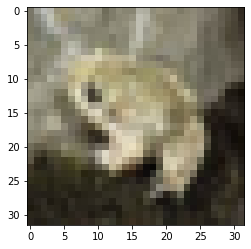

predicted ship
true ship
****************************************************************************************************


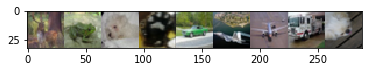

tensor([0.0145, 0.0054, 0.0160, 0.0030, 0.0095, 0.0040, 0.0065, 0.9261, 0.0152],
       device='cuda:0', dtype=torch.float64)


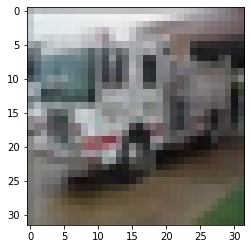

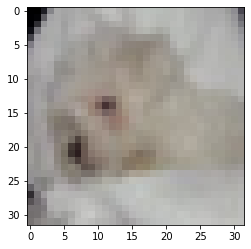

predicted truck
true truck
****************************************************************************************************


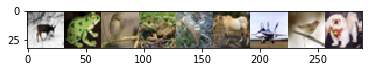

tensor([0.0005, 0.0007, 0.0654, 0.0610, 0.0589, 0.3649, 0.0432, 0.0042, 0.4012],
       device='cuda:0', dtype=torch.float64)


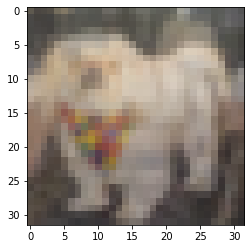

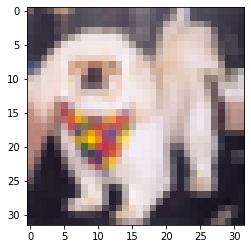

predicted horse
true horse
****************************************************************************************************


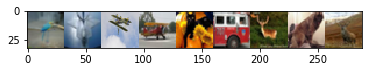

tensor([0.1298, 0.1642, 0.0014, 0.1645, 0.0074, 0.2490, 0.0363, 0.0253, 0.2221],
       device='cuda:0', dtype=torch.float64)


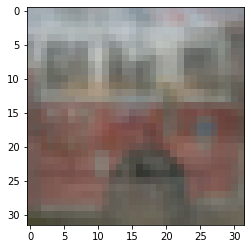

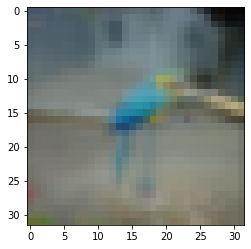

predicted horse
true truck
****************************************************************************************************


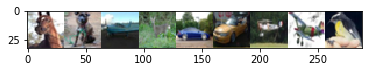

tensor([0.0051, 0.0176, 0.3915, 0.0104, 0.2090, 0.1790, 0.0321, 0.1545, 0.0007],
       device='cuda:0', dtype=torch.float64)


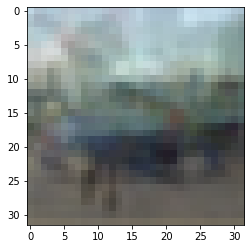

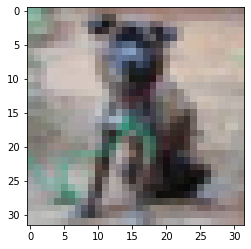

predicted truck
true horse
****************************************************************************************************


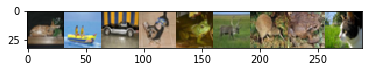

tensor([0.0697, 0.6016, 0.1031, 0.0025, 0.0162, 0.0690, 0.0078, 0.0249, 0.1050],
       device='cuda:0', dtype=torch.float64)


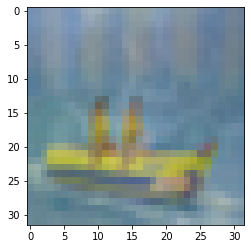

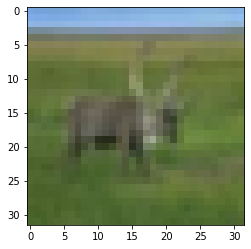

predicted ship
true ship
****************************************************************************************************


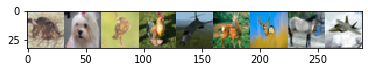

tensor([0.0059, 0.0739, 0.0098, 0.0036, 0.0860, 0.0203, 0.0057, 0.7886, 0.0063],
       device='cuda:0', dtype=torch.float64)


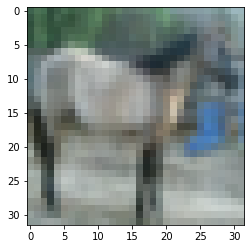

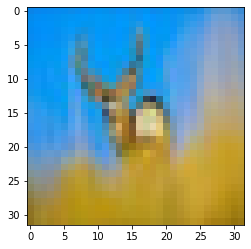

predicted horse
true horse
****************************************************************************************************


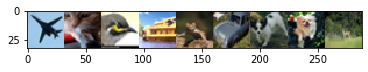

tensor([5.0799e-05, 6.2129e-02, 1.4150e-02, 8.6618e-01, 8.6677e-03, 3.9989e-03,
        1.7139e-02, 4.1826e-04, 2.7261e-02], device='cuda:0',
       dtype=torch.float64)


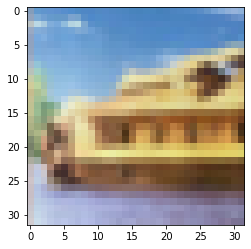

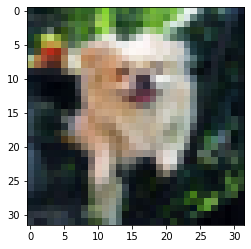

predicted truck
true ship
****************************************************************************************************


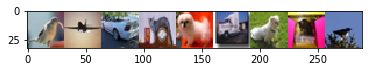

tensor([1.2526e-02, 1.7547e-02, 2.2479e-02, 6.0617e-03, 3.9911e-04, 9.3186e-01,
        2.8078e-03, 4.7211e-03, 1.5949e-03], device='cuda:0',
       dtype=torch.float64)


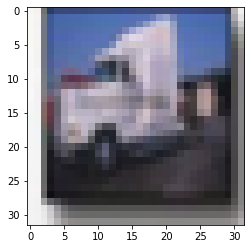

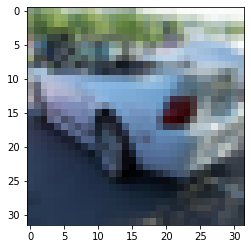

predicted truck
true truck
****************************************************************************************************


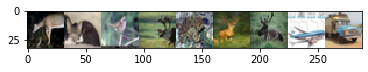

tensor([0.0949, 0.0243, 0.0090, 0.0241, 0.0689, 0.0268, 0.0341, 0.1080, 0.6099],
       device='cuda:0', dtype=torch.float64)


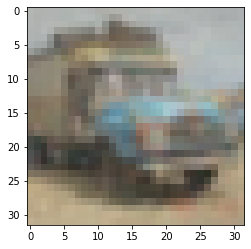

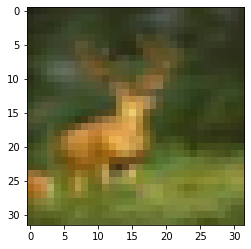

predicted truck
true truck
****************************************************************************************************


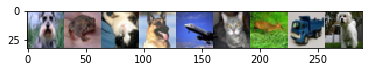

tensor([0.2724, 0.1546, 0.0039, 0.0522, 0.0132, 0.1729, 0.0113, 0.2236, 0.0957],
       device='cuda:0', dtype=torch.float64)


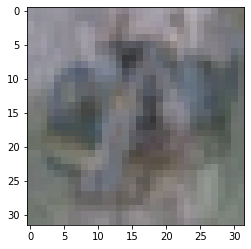

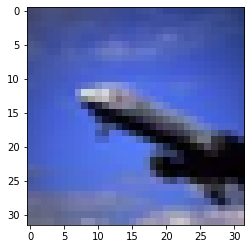

predicted horse
true truck
****************************************************************************************************


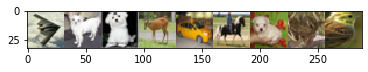

tensor([2.3477e-06, 4.3188e-04, 4.9239e-05, 2.3872e-04, 3.0977e-04, 9.9881e-01,
        6.1049e-05, 4.8268e-05, 4.6840e-05], device='cuda:0',
       dtype=torch.float64)


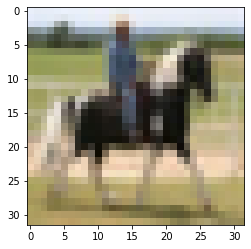

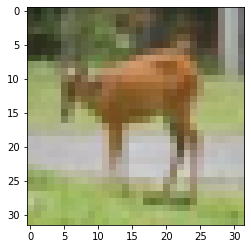

predicted horse
true horse
****************************************************************************************************


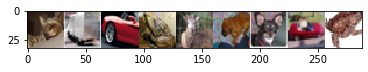

tensor([0.0107, 0.1550, 0.7346, 0.0162, 0.0341, 0.0091, 0.0159, 0.0099, 0.0146],
       device='cuda:0', dtype=torch.float64)


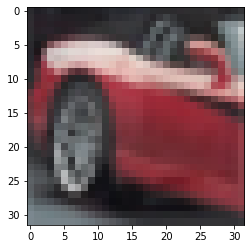

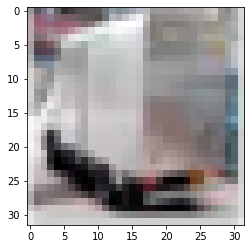

predicted horse
true truck
****************************************************************************************************


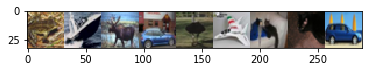

tensor([0.0075, 0.0064, 0.0612, 0.2718, 0.1995, 0.0912, 0.1027, 0.2030, 0.0567],
       device='cuda:0', dtype=torch.float64)


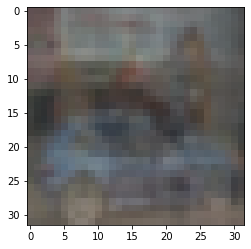

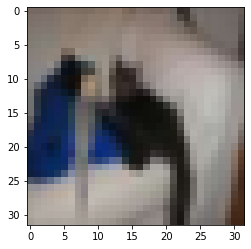

predicted ship
true ship
****************************************************************************************************


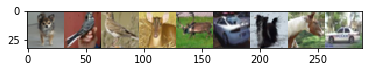

tensor([0.0166, 0.0124, 0.0363, 0.0257, 0.3050, 0.0553, 0.0757, 0.1272, 0.3459],
       device='cuda:0', dtype=torch.float64)


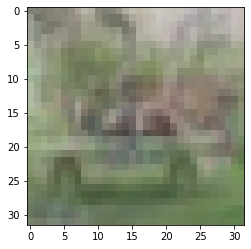

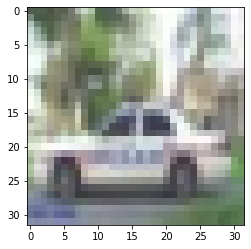

predicted ship
true horse
****************************************************************************************************


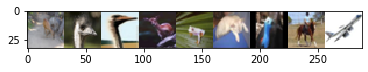

tensor([4.5717e-02, 2.1141e-02, 9.6097e-05, 4.5861e-03, 2.1510e-02, 7.6688e-04,
        1.9949e-02, 8.8616e-01, 7.6672e-05], device='cuda:0',
       dtype=torch.float64)


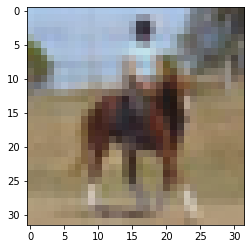

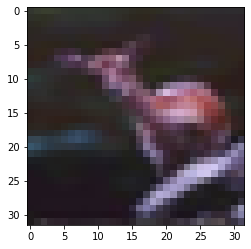

predicted horse
true horse
****************************************************************************************************


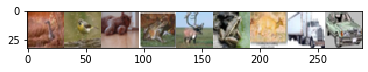

tensor([7.0861e-04, 5.8817e-05, 3.5740e-04, 5.5667e-05, 1.4285e-04, 1.6802e-04,
        1.1735e-04, 9.9801e-01, 3.7962e-04], device='cuda:0',
       dtype=torch.float64)


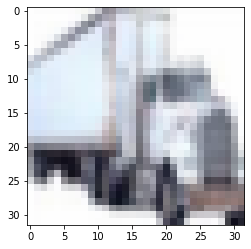

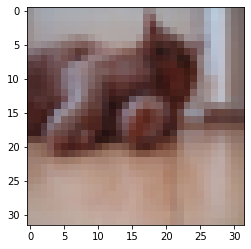

predicted truck
true truck
****************************************************************************************************


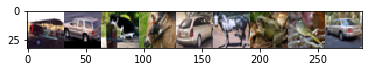

tensor([1.8369e-03, 4.3945e-03, 9.2519e-04, 2.3258e-04, 2.5092e-03, 9.8577e-01,
        1.2159e-03, 2.8263e-03, 2.8883e-04], device='cuda:0',
       dtype=torch.float64)


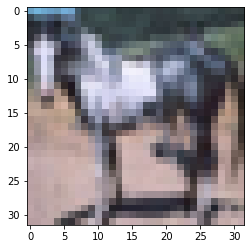

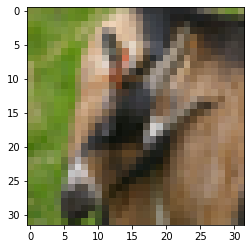

predicted horse
true horse
****************************************************************************************************


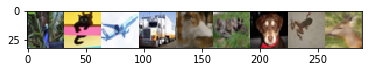

tensor([9.6562e-03, 5.5061e-06, 5.9483e-04, 9.6207e-01, 1.5471e-02, 8.6427e-03,
        2.7297e-04, 2.4150e-03, 8.7068e-04], device='cuda:0',
       dtype=torch.float64)


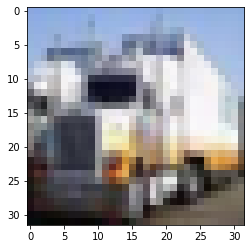

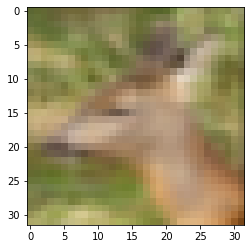

predicted truck
true truck
****************************************************************************************************


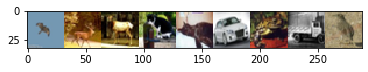

tensor([9.5396e-05, 9.7686e-05, 1.9475e-03, 1.5073e-04, 1.1181e-03, 2.5070e-05,
        3.1956e-04, 9.9597e-01, 2.7201e-04], device='cuda:0',
       dtype=torch.float64)


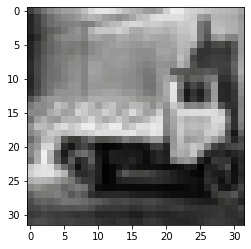

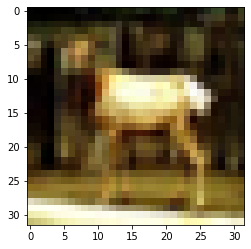

predicted truck
true truck
****************************************************************************************************


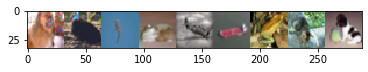

tensor([1.8125e-02, 1.8383e-02, 1.7869e-02, 4.8534e-02, 1.0841e-01, 7.8663e-01,
        1.7884e-04, 1.6626e-04, 1.7041e-03], device='cuda:0',
       dtype=torch.float64)


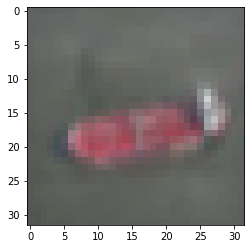

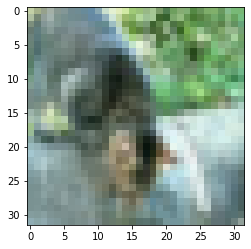

predicted ship
true ship
****************************************************************************************************


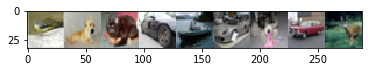

tensor([0.0020, 0.0637, 0.0122, 0.0109, 0.7159, 0.0586, 0.0045, 0.1273, 0.0049],
       device='cuda:0', dtype=torch.float64)


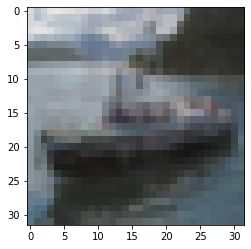

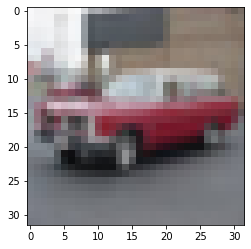

predicted ship
true ship
****************************************************************************************************


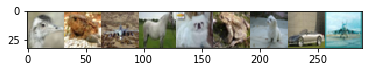

tensor([0.0236, 0.0146, 0.0088, 0.7213, 0.0491, 0.0227, 0.0207, 0.1144, 0.0248],
       device='cuda:0', dtype=torch.float64)


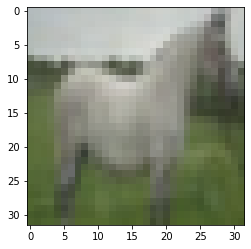

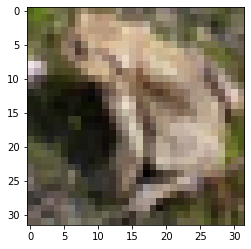

predicted horse
true horse
****************************************************************************************************


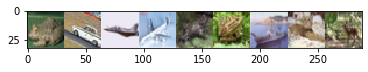

tensor([0.0413, 0.4438, 0.0295, 0.0396, 0.0774, 0.0087, 0.3357, 0.0021, 0.0219],
       device='cuda:0', dtype=torch.float64)


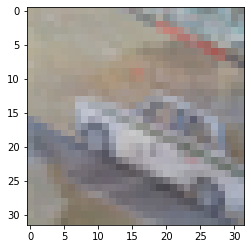

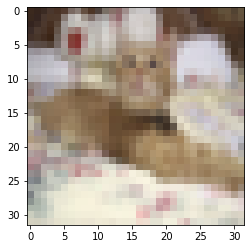

predicted horse
true ship
****************************************************************************************************


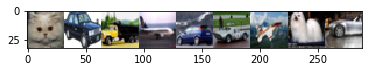

tensor([0.0853, 0.0873, 0.3442, 0.0044, 0.2449, 0.0481, 0.0756, 0.0078, 0.1025],
       device='cuda:0', dtype=torch.float64)


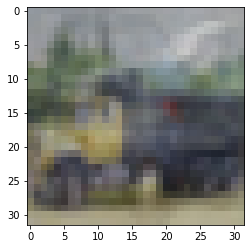

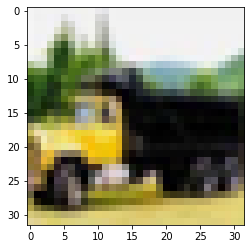

predicted truck
true truck
****************************************************************************************************


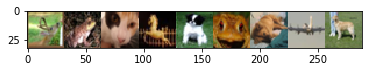

tensor([0.0023, 0.0014, 0.0380, 0.0991, 0.0153, 0.2035, 0.2269, 0.3560, 0.0575],
       device='cuda:0', dtype=torch.float64)


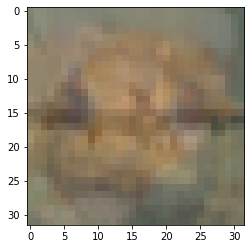

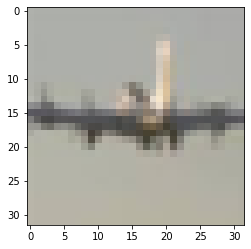

predicted horse
true horse
****************************************************************************************************


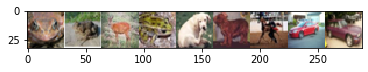

tensor([0.0455, 0.0367, 0.2753, 0.0272, 0.0597, 0.1924, 0.2800, 0.0442, 0.0392],
       device='cuda:0', dtype=torch.float64)


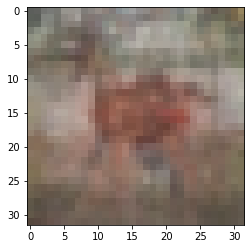

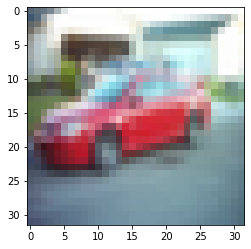

predicted horse
true horse
****************************************************************************************************


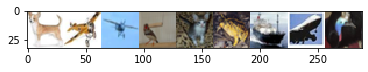

tensor([3.9238e-04, 3.0651e-04, 5.1012e-05, 1.1926e-03, 2.3937e-03, 1.7509e-04,
        9.9264e-01, 6.1276e-04, 2.2393e-03], device='cuda:0',
       dtype=torch.float64)


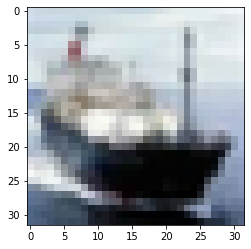

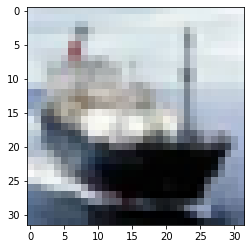

predicted ship
true ship
****************************************************************************************************


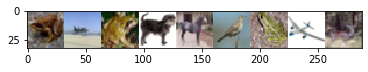

tensor([3.8291e-03, 1.2887e-03, 6.4576e-05, 1.8196e-03, 9.3349e-01, 2.4877e-02,
        5.0768e-03, 2.1293e-03, 2.7429e-02], device='cuda:0',
       dtype=torch.float64)


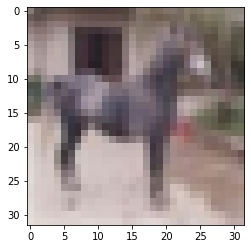

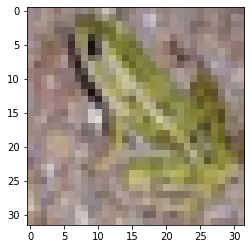

predicted horse
true horse
****************************************************************************************************


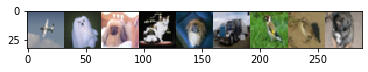

tensor([0.0157, 0.0031, 0.0172, 0.0029, 0.0011, 0.9393, 0.0018, 0.0159, 0.0030],
       device='cuda:0', dtype=torch.float64)


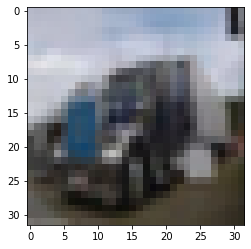

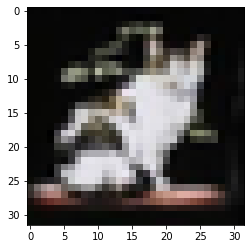

predicted truck
true truck
****************************************************************************************************


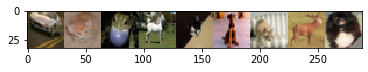

tensor([1.1524e-02, 1.5472e-02, 7.2631e-04, 9.4921e-01, 3.6029e-04, 6.4864e-04,
        1.5618e-02, 3.0372e-03, 3.3992e-03], device='cuda:0',
       dtype=torch.float64)


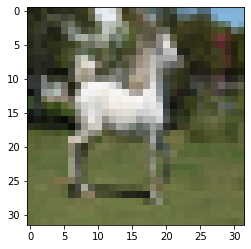

predicted horse
true horse
****************************************************************************************************


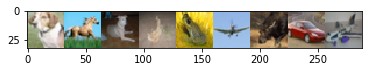

tensor([1.0386e-03, 8.6348e-01, 3.5833e-02, 1.4811e-02, 2.1000e-05, 2.7775e-04,
        2.4000e-02, 3.5843e-02, 2.4700e-02], device='cuda:0',
       dtype=torch.float64)


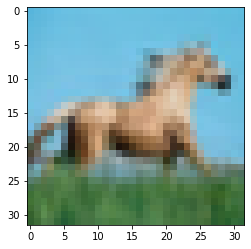

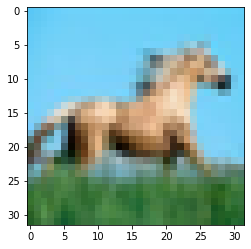

predicted horse
true horse
****************************************************************************************************


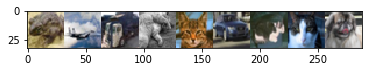

tensor([7.5268e-04, 6.1831e-03, 9.7643e-01, 4.7444e-03, 6.8507e-04, 9.6621e-05,
        4.0220e-04, 6.2322e-03, 4.4735e-03], device='cuda:0',
       dtype=torch.float64)


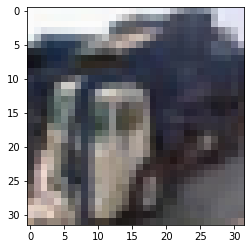

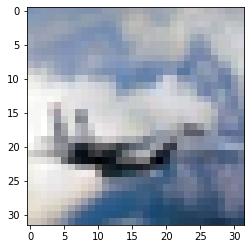

predicted truck
true truck
****************************************************************************************************


tensor([3.4971e-06, 7.0864e-04, 1.7364e-03, 2.1991e-03, 9.9276e-01, 7.3985e-04,
        1.1867e-03, 3.6752e-04, 2.9540e-04], device='cuda:0',
       dtype=torch.float64)


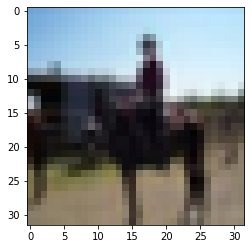

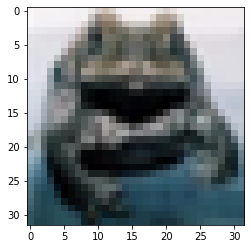

predicted horse
true horse
****************************************************************************************************


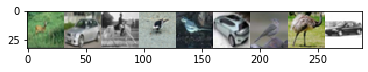

tensor([0.0202, 0.0043, 0.6791, 0.0107, 0.1193, 0.0170, 0.1362, 0.0032, 0.0101],
       device='cuda:0', dtype=torch.float64)


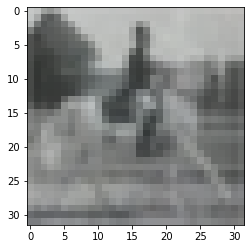

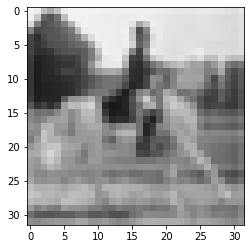

predicted horse
true horse
****************************************************************************************************


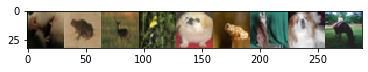

tensor([0.0519, 0.0010, 0.0673, 0.0057, 0.0136, 0.0206, 0.2826, 0.0021, 0.5552],
       device='cuda:0', dtype=torch.float64)


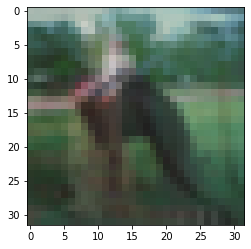

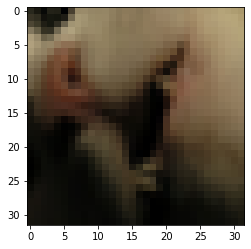

predicted horse
true horse
****************************************************************************************************


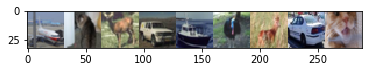

tensor([0.0097, 0.0080, 0.0334, 0.0120, 0.9142, 0.0116, 0.0014, 0.0031, 0.0066],
       device='cuda:0', dtype=torch.float64)


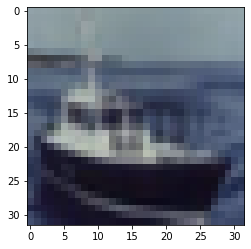

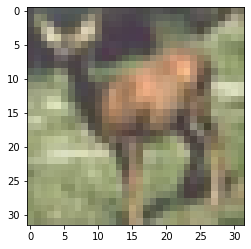

predicted ship
true ship
****************************************************************************************************


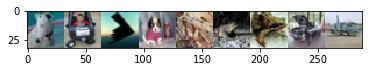

tensor([0.1516, 0.1267, 0.0028, 0.0866, 0.1907, 0.0269, 0.0323, 0.0303, 0.3519],
       device='cuda:0', dtype=torch.float64)


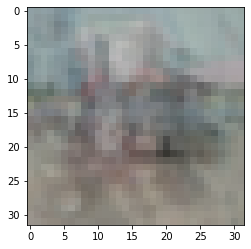

predicted ship
true truck
****************************************************************************************************


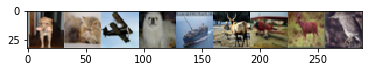

tensor([3.7663e-04, 2.1825e-02, 2.4966e-03, 2.5450e-03, 2.7420e-01, 5.0327e-01,
        1.2774e-01, 6.3378e-02, 4.1747e-03], device='cuda:0',
       dtype=torch.float64)


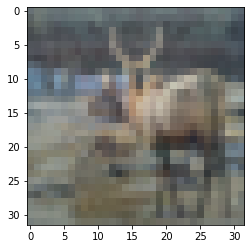

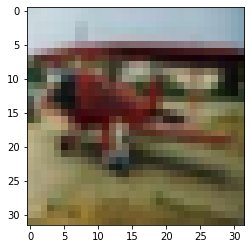

predicted ship
true ship
****************************************************************************************************


tensor([0.0057, 0.0356, 0.3132, 0.0236, 0.3847, 0.0476, 0.0627, 0.0091, 0.1177],
       device='cuda:0', dtype=torch.float64)


predicted horse
true ship
****************************************************************************************************


tensor([9.9832e-01, 6.9686e-04, 2.4058e-04, 1.0237e-04, 1.0554e-05, 1.0261e-04,
        3.9933e-05, 9.9060e-05, 3.8717e-04], device='cuda:0',
       dtype=torch.float64)


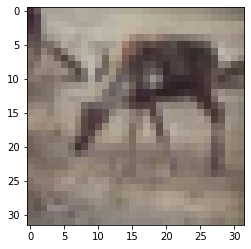

predicted horse
true horse
****************************************************************************************************


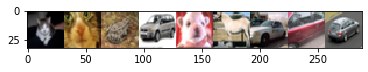

tensor([3.7245e-04, 7.8295e-04, 7.9378e-04, 1.2182e-04, 4.2065e-05, 9.9014e-01,
        2.5264e-03, 3.0469e-03, 2.1712e-03], device='cuda:0',
       dtype=torch.float64)


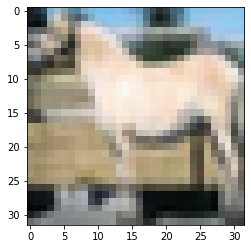

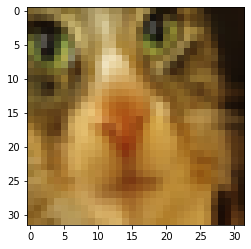

predicted horse
true horse
****************************************************************************************************


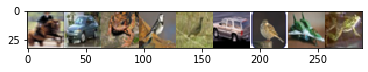

tensor([0.0246, 0.0914, 0.1260, 0.0986, 0.0551, 0.1915, 0.1520, 0.2201, 0.0406],
       device='cuda:0', dtype=torch.float64)


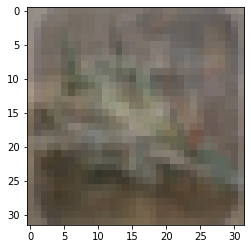

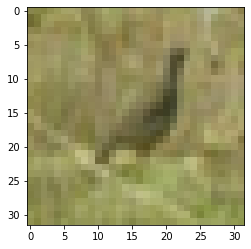

predicted ship
true horse
****************************************************************************************************


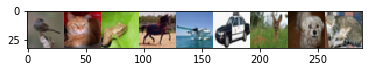

tensor([3.2085e-03, 1.5560e-03, 3.7749e-05, 9.8185e-01, 1.1502e-03, 9.3650e-04,
        3.3995e-03, 3.3412e-03, 4.5242e-03], device='cuda:0',
       dtype=torch.float64)


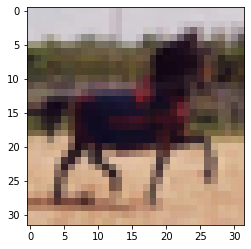

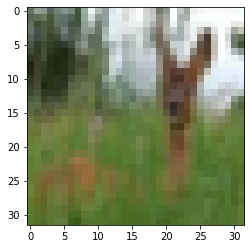

predicted horse
true horse
Accuracy of the network on the 10000 test images: 81 %
total correct 8190
total test set images 10000


In [79]:
correct = 0
total = 0
flag =1
with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs,labels = inputs.to("cuda"),labels.to("cuda") 
    avg_images , alphas = where_net(inputs)
    outputs = what_net(avg_images)
    _, predicted = torch.max(outputs.data, 1)


    if flag==1 :
      for j in range (50):
        print("*"*100)
        img1 = torch.cat((inputs[j][0], inputs[j][1], inputs[j][2], inputs[j][3], inputs[j][4], inputs[j][5], inputs[j][6], inputs[j][7], inputs[j][8]) , 2)
        display(img1.cpu())

        print(alphas[j])

        img2 = avg_images[j]
        display(img2.cpu())

        img3 = inputs[j][fore_idx_test[j]]
        display(img3.cpu())

        print("predicted", classes[predicted[j]+7])
        print("true", classes[labels[j]+7])

      flag =0


    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
print("total correct", correct)
print("total test set images", total)

In [0]:
a = torch.tensor([0.0071, 0.0466, 0.0025, 0.0282, 0.0140, 0.0067, 0.0145, 0.8750, 0.0055])

In [81]:
print(torch.argmax(a) == 7)
print(batch)

tensor(True)
250


In [82]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

train_loader1 = DataLoader( msd,batch_size= batch ,shuffle=False)
with torch.no_grad():
  for data in train_loader1:
    inputs, labels , fore_idx = data
    inputs,labels = inputs.to("cuda"),labels.to("cuda") 
    avg_images , alphas = where_net(inputs)
    outputs = what_net(avg_images)
    _, predicted = torch.max(outputs.data, 1)
    
    for j in range (batch):
      focus = torch.argmax(alphas[j])
      
      if(alphas[j][focus] >= 0.5):
        argmax_more_than_half +=1
      else:
        argmax_less_than_half +=1
        
      if(focus == fore_idx[j] and predicted[j] == labels[j]):
        focus_true_pred_true += 1
        
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true +=1
        
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false +=1
        
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false +=1
      
#       print("*"*100)
#       img1 = torch.cat((inputs[j][0], inputs[j][1], inputs[j][2], inputs[j][3], inputs[j][4], inputs[j][5], inputs[j][6], inputs[j][7], inputs[j][8]) , 2)
#       display(img1)

#       print(alphas[j])

#       img2 = avg_images[j]
#       display(img2)

#       img3 = inputs[j][fore_idx[j]]
#       display(img3)

#       print("predicted", classes[predicted[j]+7])
#       print("true", classes[labels[j]+7])

     
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true",focus_true_pred_true)
print("focus_false_pred_true",focus_false_pred_true )
print("focus_true_pred_false",focus_true_pred_false )
print("focus_false_pred_false",focus_false_pred_false)

print("argmax_more_than_half",argmax_more_than_half)
print("argmax_less_than_half",argmax_less_than_half)

Accuracy of the network on the 30000 train images: 99 %
total correct 29983
total train set images 30000
focus_true_pred_true 24179
focus_false_pred_true 5804
focus_true_pred_false 0
focus_false_pred_false 17
argmax_more_than_half 23895
argmax_less_than_half 6105


In [83]:
bg_idx = np.random.randint(0,35000,8)
fg_idx = np.random.randint(0,15000)
fg = np.random.randint(0,9)
fore_idx_test.append(fg)
image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
test_images.append(image_list)
test_label.append(label)
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs,labels = inputs.to("cuda"),labels.to("cuda") 
    avg_images , alphas = where_net(inputs)
    outputs = what_net(avg_images)

    _, predicted = torch.max(outputs.data, 1)
    
    for j in range (batch):
      focus = torch.argmax(alphas[j])
      
      if(alphas[j][focus] >= 0.5):
        argmax_more_than_half +=1
      else:
        argmax_less_than_half +=1
        
      if(focus == fore_idx[j] and predicted[j] == labels[j]):
        focus_true_pred_true += 1
        
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true +=1
        
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false +=1
        
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false +=1
      
#       print("*"*100)
#       img1 = torch.cat((inputs[j][0], inputs[j][1], inputs[j][2], inputs[j][3], inputs[j][4], inputs[j][5], inputs[j][6], inputs[j][7], inputs[j][8]) , 2)
#       display(img1)

#       print(alphas[j])

#       img2 = avg_images[j]
#       display(img2)

#       img3 = inputs[j][fore_idx[j]]
#       display(img3)

#       print("predicted", classes[predicted[j]+7])
#       print("true", classes[labels[j]+7])

     
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true",focus_true_pred_true)
print("focus_false_pred_true",focus_false_pred_true )
print("focus_true_pred_false",focus_true_pred_false )
print("focus_false_pred_false",focus_false_pred_false)

print("argmax_more_than_half",argmax_more_than_half)
print("argmax_less_than_half",argmax_less_than_half)

Accuracy of the network on the 30000 train images: 81 %
total correct 8190
total train set images 10000
focus_true_pred_true 7082
focus_false_pred_true 1108
focus_true_pred_false 415
focus_false_pred_false 1395
argmax_more_than_half 7428
argmax_less_than_half 2572


In [0]:
# epoch = 100
# for i in range(epoch):
#   if (i %40) <20:
#     print("What",i)
#   elif (i%40)>20:
#     print("Where",i)